## Length of the code {-}
No restriction

<span style="color: red;">*Note: Any AI tools used must be disclosed in the final report.*</span>

**Delete this section from the report, when using this template.** 

## Import necessary packages

In [28]:
# load in packages
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Q1.

### Q2.

### Q3. Membership and Ride Frequency Analysis
*By Eduardo Sourd*

Question: How do annual members and casual riders use Divvy bikes differently in Chicago, in terms of ride frequency, duration, time of day, and station patterns and how do these differences manifest over time, across neighborhoods, and in response to external factors such as demographics?

#### Step 1: Clean up data

In [29]:
# Load data from datasets
divvy_data_eduardo = pd.read_csv('datasets/eduardodatasets/202412-divvy-tripdata.csv')
community_boundaries = pd.read_csv("datasets/eduardodatasets/Boundaries_-_Community_Areas_20251205.csv")
ACS_data = pd.read_csv("datasets/eduardodatasets/ACS_5_Year_Data_by_Community_Area_-_Most_Recent_Year_20251206.csv")


# Clean Divvy Data
divvy_data_eduardo['started_at'] = pd.to_datetime(divvy_data_eduardo['started_at'], errors='coerce', format='%m/%d/%y %I:%M %p')
divvy_data_eduardo['ended_at'] = pd.to_datetime(divvy_data_eduardo['ended_at'], errors='coerce', format='%m/%d/%y %I:%M %p')

divvy_data_eduardo = divvy_data_eduardo.dropna(subset=['started_at', 'ended_at'])

divvy_data_eduardo['ride_length_min'] = (divvy_data_eduardo['ended_at'] - divvy_data_eduardo['started_at']).dt.total_seconds() / 60

# Filter: ride_length_min must be > 1 minute AND <= 24 hours
divvy_data_eduardo = divvy_data_eduardo[(divvy_data_eduardo['ride_length_min'] > 1) & (divvy_data_eduardo['ride_length_min'] <= 24*60)]

# Convert start and end station IDs to strings
divvy_data_eduardo['start_station_id'] = divvy_data_eduardo['start_station_id'].astype(str)
divvy_data_eduardo['end_station_id'] = divvy_data_eduardo['end_station_id'].astype(str)


divvy_data_eduardo['date']        = divvy_data_eduardo['started_at'].dt.date
divvy_data_eduardo['day_of_week'] = divvy_data_eduardo['started_at'].dt.day_name()
divvy_data_eduardo['hour_of_day'] = divvy_data_eduardo['started_at'].dt.hour
divvy_data_eduardo['month']       = divvy_data_eduardo['started_at'].dt.month
divvy_data_eduardo['year']        = divvy_data_eduardo['started_at'].dt.year
divvy_data_eduardo['is_weekend']  = divvy_data_eduardo['day_of_week'].isin(['Saturday', 'Sunday'])


# connect divvy start and end points to lat and lon
divvy_data_eduardo['start_point'] = divvy_data_eduardo.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data_eduardo['end_point'] = divvy_data_eduardo.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)

### Step 2: Spatial Join to Neighborhoods / Community Areas

In [30]:
# Convert Community Boundaries to GeoDataFrame
# Parse the geometry column (WKT format)
community_boundaries['geometry'] = community_boundaries['the_geom'].apply(lambda x: wkt.loads(x))

# Create GeoDataFrame
gdf_boundaries = gpd.GeoDataFrame(community_boundaries, geometry='geometry', crs='EPSG:4326')


# Create GeoDataFrame from start points
gdf_start_points = gpd.GeoDataFrame(
    divvy_data_eduardo[['ride_id', 'start_station_name', 'start_lat', 'start_lng']],
    geometry=gpd.points_from_xy(divvy_data_eduardo['start_lng'], divvy_data_eduardo['start_lat']),
    crs='EPSG:4326'
)

# Create GeoDataFrame from end points
gdf_end_points = gpd.GeoDataFrame(
    divvy_data_eduardo[['ride_id', 'end_station_name', 'end_lat', 'end_lng']],
    geometry=gpd.points_from_xy(divvy_data_eduardo['end_lng'], divvy_data_eduardo['end_lat']),
    crs='EPSG:4326'
)

# Spatial join: for each start point, find which community area polygon contains it
sjoin_start = gpd.sjoin(gdf_start_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                         how='left', predicate='within')

# Extract the community area for start
divvy_data_eduardo['start_community'] = sjoin_start['COMMUNITY'].values
divvy_data_eduardo['start_area_number'] = sjoin_start['AREA_NUMBE'].values

# Spatial join: for each end point, find which community area polygon contains it
sjoin_end = gpd.sjoin(gdf_end_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                       how='left', predicate='within')

# Extract the community area for end
divvy_data_eduardo['end_community'] = sjoin_end['COMMUNITY'].values
divvy_data_eduardo['end_area_number'] = sjoin_end['AREA_NUMBE'].values

### Step 3: Attach Census Demographics

In [31]:
# Clean ACS data - standardize community names and numeric columns

# Standardize community area names: uppercase and strip whitespace
ACS_data['community_area_normalized'] = ACS_data['Community Area'].str.upper().str.strip()

# Select key demographic columns: income brackets, racial/ethnic categories, population
income_cols = ['Under $25,000', '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $125,000', '$125,000 +']
race_cols = ['White', 'Black or African American', 'Asian', 'Hispanic or Latino']
key_demo_cols = ['community_area_normalized', 'Total Population'] + income_cols + race_cols

ACS_clean = ACS_data[key_demo_cols].copy()


# Convert all numeric columns from comma-separated strings to float
numeric_cols = income_cols + race_cols + ['Total Population']
for col in numeric_cols:
    # Convert to string, remove commas, then to float
    ACS_clean[col] = ACS_clean[col].astype(str).str.replace(',', '', regex=False).astype(float)


# Standardize divvy_data community names (should already be done from Step 3, but ensuring consistency)
divvy_data_eduardo['start_community_normalized'] = divvy_data_eduardo['start_community'].str.upper().str.strip()
divvy_data_eduardo['end_community_normalized'] = divvy_data_eduardo['end_community'].str.upper().str.strip()


# Check for mismatches between divvy and ACS community names
divvy_communities = set(divvy_data_eduardo['start_community_normalized'].dropna().unique())
acs_communities = set(ACS_clean['community_area_normalized'].unique())

# Merge divvy_data with ACS demographics using start_community
divvy_with_acs = divvy_data_eduardo.merge(
    ACS_clean,
    left_on='start_community_normalized',
    right_on='community_area_normalized',
    how='left'
)

# Create community-level summary with demographics and ridership metrics

community_summary = divvy_with_acs.groupby('start_community_normalized', dropna=False).agg(
    total_trips=('ride_id', 'count'),
    member_trips=('member_casual', lambda s: (s == 'member').sum()),
    casual_trips=('member_casual', lambda s: (s == 'casual').sum()),
    avg_ride_length=('ride_length_min', 'mean'),
    median_ride_length=('ride_length_min', 'median'),
    total_population=('Total Population', 'first'),
    under_25k=('Under $25,000', 'first'),
    income_25_50k=('$25,000 to $49,999', 'first'),
    income_50_75k=('$50,000 to $74,999', 'first'),
    income_75_125k=('$75,000 to $125,000', 'first'),
    income_125k_plus=('$125,000 +', 'first'),
    white=('White', 'first'),
    black_african_american=('Black or African American', 'first'),
    asian=('Asian', 'first'),
    hispanic_latino=('Hispanic or Latino', 'first')
).reset_index()

# Create derived metrics
community_summary['member_share'] = (community_summary['member_trips'] / 
                                      community_summary['total_trips']).round(4)
community_summary['casual_share'] = (community_summary['casual_trips'] / 
                                      community_summary['total_trips']).round(4)

# Trips per 1000 residents (only for communities with population data)
community_summary['trips_per_1k_residents'] = np.where(
    community_summary['total_population'].notna(),
    (community_summary['total_trips'] / community_summary['total_population'] * 1000).round(2),
    np.nan
)

# Calculate income diversity: coefficient of variation of income brackets
income_bracket_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
def income_diversity(row):
    income_vals = [row[col] for col in income_bracket_cols if pd.notna(row[col])]
    if len(income_vals) == 0 or sum(income_vals) == 0:
        return np.nan
    mean_income = np.mean(income_vals)
    std_income = np.std(income_vals)
    return (std_income / mean_income).round(3) if mean_income != 0 else np.nan

community_summary['income_diversity_cv'] = community_summary.apply(income_diversity, axis=1)

# Calculate racial diversity: using Simpson's Diversity Index
race_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
def racial_diversity(row):
    race_vals = [row[col] for col in race_cols if pd.notna(row[col])]
    if len(race_vals) == 0 or sum(race_vals) == 0:
        return np.nan
    total = sum(race_vals)
    proportions = [v / total for v in race_vals]
    # Simpson's Diversity Index: 1 - sum(p_i^2)
    simpson_index = 1 - sum([p**2 for p in proportions])
    return round(simpson_index, 3)

community_summary['racial_diversity_index'] = community_summary.apply(racial_diversity, axis=1)

### Q4. Mobility and Safety Datasets
*By Isabella Yan (Chisa)*

Question: How do traffic crashes, adult physical inactivity, and Divvy station accessibility relate across Chicago’s community areas, and do neighborhoods with higher physical inactivity experience different crash rates or different access to bike-share infrastructure?

#### Step 1: Clean up data

In [32]:
#
# 1.1. load data from healthdatasets
#
community_boundary_data = pd.read_csv('./datasets/healthdatasets/Boundaries_-_Community_Areas_20251201.csv')
divvy_data = pd.read_csv('./datasets/healthdatasets/202412-divvy-tripdata.csv')
health_data = pd.read_csv('./datasets/healthdatasets/2024chicagohealthatlas_raw.csv')

#
# 1.2. Clean community area boundaries
#

# rename columns
community_boundary_data = community_boundary_data.rename(columns={
    'AREA_NUMBE': 'community_area_number',
    'COMMUNITY': 'community_area_name',
    'AREA_NUM_1': 'community_area_number_dup',
    'the_geom': 'wkt_geometry',
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_length'
})

# standardize community name 
community_boundary_data['community_area_name'] = (
    community_boundary_data['community_area_name'].str.title()
)

# use wkt from shapely to convert the wkt to geometry
community_boundary_data['geometry'] = community_boundary_data['wkt_geometry'].apply(wkt.loads)

# convert to geopanda dataframe 
community_boundary_data = gpd.GeoDataFrame(
    community_boundary_data,
    geometry='geometry',
    crs="EPSG:4326"
)

# extract centroids (useful for lat/lon)
# reproject to Illinois StatePlane (good for Chicago)
boundary_projected = community_boundary_data.to_crs(epsg=3435)

# compute centroids in that CRS
centroids = boundary_projected.centroid

# convert centroids back to WGS84 (lat/lon)
centroids_wgs = centroids.to_crs(epsg=4326)

# store results
community_boundary_data['centroid_lat'] = centroids_wgs.y
community_boundary_data['centroid_lon'] = centroids_wgs.x

#
# 1.3. Clean divvy data
#

# convert all timestamps to datetime objects 
divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'])
divvy_data['ended_at'] = pd.to_datetime(divvy_data['ended_at'])

# remove invalid rides
divvy_data = divvy_data[
    (divvy_data['ended_at'] > divvy_data['started_at']) &
    (divvy_data['start_lat'].notna()) &
    (divvy_data['start_lng'].notna())
]

# create duration + data features
divvy_data['ride_minutes'] = (divvy_data['ended_at'] - divvy_data['started_at']).dt.total_seconds() / 60
divvy_data['date'] = divvy_data['started_at'].dt.date
divvy_data['hour'] = divvy_data['started_at'].dt.hour
divvy_data['day_of_week'] = divvy_data['started_at'].dt.day_name()

# connect divvy start and end points to lat and lon 
divvy_data['start_point'] = divvy_data.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data['end_point'] = divvy_data.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)


#
# 1.4. Clean health data 
#

# drop metadata rows
health_data = health_data.iloc[4:].reset_index(drop=True)

# rename columns to understand them    
health_data = health_data.rename(columns={
    'Name': 'community_area_name',
    'GEOID': 'community_area_number',
    'HCSPAP_2023-2024': 'physical_inactivity_rate',
    'HCSPAP_2023-2024_moe': 'physical_inactivity_rate_moe',
    'HCSPA_2023-2024': 'physical_inactivity_count',
    'HCSPA_2023-2024_moe': 'physical_inactivity_count_moe',
    'TRC_2024': 'traffic_crashes',
    'TRC_2024_moe': 'traffic_crashes_moe'
})

# standardize the names
health_data['community_area_name'] = (
    health_data['community_area_name'].str.title()
)

# convert geoid to int 
health_data['community_area_number'] = (
    health_data['community_area_number'].astype(int)
)

# drop the layer col
health_data = health_data.drop(columns=['Layer'])


#### Step 2: Convert Divvy start points to GeoDataframe, assign to community areas for counts

In [33]:
#
# 2.1. Convert Divvy start points into the geoframe 
#
community_boundary_data = community_boundary_data.to_crs(epsg=3435)

# Convert Divvy points to the same CRS
divvy_gdf = gpd.GeoDataFrame(
    divvy_data,
    geometry=divvy_data['start_point'],
    crs="EPSG:4326"
).to_crs(epsg=3435)

# 
# 2.2. Assign each ride's starting neighborhood  
#
divvy_with_area = gpd.sjoin(
    divvy_gdf,
    community_boundary_data[['community_area_number', 'community_area_name', 'geometry']],
    how='left',
    predicate='within'
)


### Step 3: Get Divvy station counts to measure accessibility per neighborhood. 

In [34]:
#
# 3.1. Identify only unique stations
#
unique_stations = divvy_with_area[
    ['start_station_name', 'community_area_number', 'community_area_name', 'geometry']
].drop_duplicates()

#
# 3.2. Count stations per neighborhood. 
#
station_density = (
    unique_stations
    .groupby('community_area_number')
    .size()
    .reset_index(name='divvy_station_count')
)

#### Step 4: Aggregate Divvy rides and statistics per community area

In [35]:
#
# 4.1. Aggregate Divvy ride volume per community area
#
rides_per_area = (
    divvy_with_area
    .groupby('community_area_number')
    .size()
    .reset_index(name='total_rides_starting_here')
)

#
# 4.2 Merge all Divvy aggregations together
#
divvy_summary = station_density.merge(
    rides_per_area,
    on='community_area_number',
    how='left'
)

#
# 4.3. Merge Divvy summary with health data
#
community_stats = health_data.merge(
    divvy_summary,
    on='community_area_number',
    how='left'
)

community_stats = community_stats.merge(
    community_boundary_data[['community_area_number', 'geometry', 'centroid_lat', 'centroid_lon']],
    on='community_area_number',
    how='left'
)

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Name of person doing the analysis>*

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By Eduardo Sourd*

### Analyze Trips by Membership Type

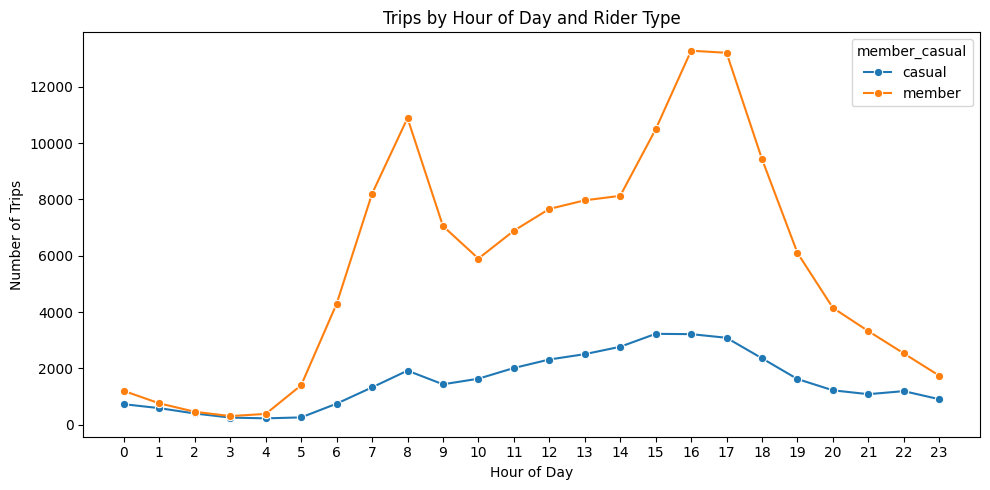

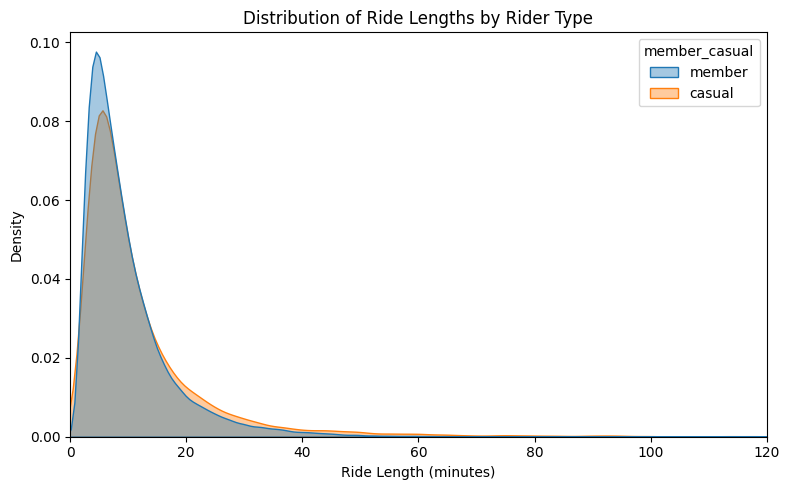

In [36]:
# Rides per hour of day by rider type
hourly_counts = (
    divvy_data_eduardo
    .groupby(['hour_of_day', 'member_casual'])['ride_id']
    .count()
    .reset_index(name='trip_count')
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=hourly_counts,
    x='hour_of_day',
    y='trip_count',
    hue='member_casual',
    marker='o'
)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Trips by Hour of Day and Rider Type')
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))

# Cap at 120 minutes for visibility
plot_data = divvy_data_eduardo[divvy_data_eduardo['ride_length_min'] <= 120].copy()

sns.kdeplot(
    data=plot_data,
    x='ride_length_min',
    hue='member_casual',
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlabel('Ride Length (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Ride Lengths by Rider Type')
plt.xlim(0, 120)
plt.tight_layout()
plt.show()

### Create Heatmap to better visualize ride start times by membership type

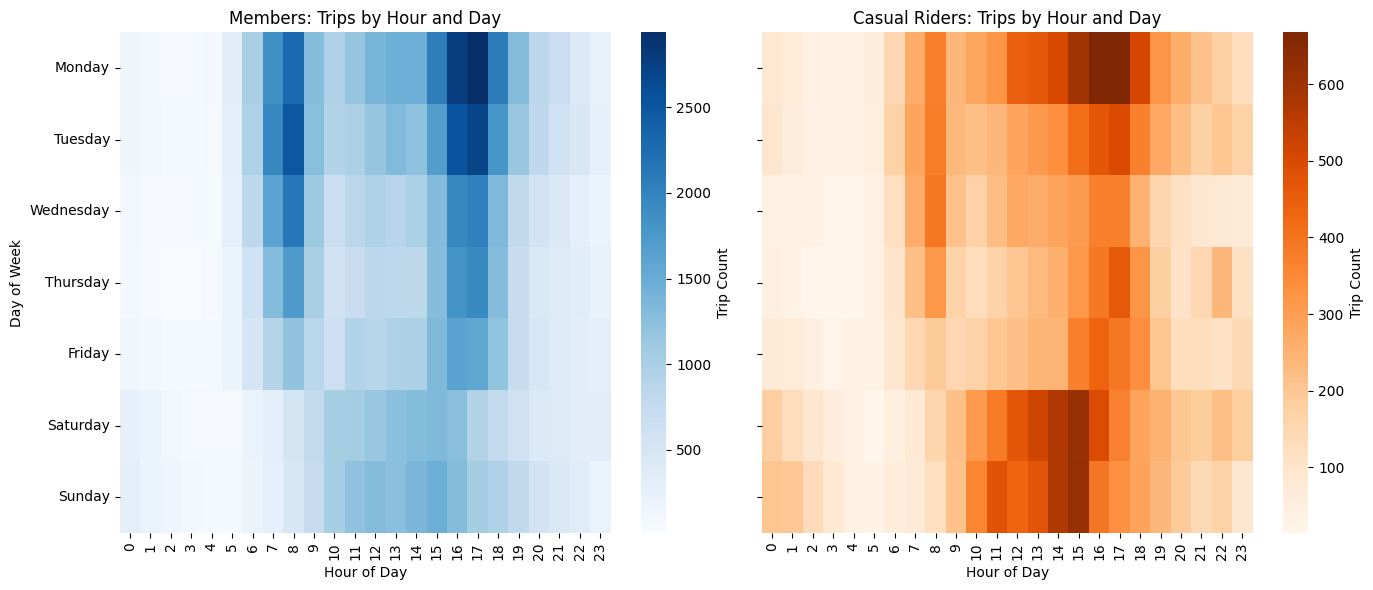

In [37]:
# Ensure a logical weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
divvy_data_eduardo['day_of_week'] = pd.Categorical(divvy_data_eduardo['day_of_week'], categories=weekday_order, ordered=True)


# Aggregate trips by hour and day for each rider type
hour_dow_counts = (
    divvy_data_eduardo
    .groupby(['member_casual', 'day_of_week', 'hour_of_day'], observed=True)['ride_id']
    .count()
    .reset_index(name='trip_count')
)

# Pivot into matrices for members and casuals
member_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'member'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

casual_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'casual'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.heatmap(
    member_pivot,
    ax=axes[0],
    cmap='Blues',
    cbar_kws={'label': 'Trip Count'}
)
axes[0].set_title('Members: Trips by Hour and Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Day of Week')

sns.heatmap(
    casual_pivot,
    ax=axes[1],
    cmap='Oranges',
    cbar_kws={'label': 'Trip Count'}
)
axes[1].set_title('Casual Riders: Trips by Hour and Day')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


### Visualize Demographic-Ridership Relationships

In [38]:
# Demographic and Ridership Correlations

# Calculate income concentration percentages
income_total_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
for col in income_total_cols:
    total_income = community_summary[income_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_income * 100).round(1)

# Calculate racial composition percentages
race_total_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
for col in race_total_cols:
    total_race = community_summary[race_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_race * 100).round(1)

# Correlation analysis: Demographics vs Member Share
demo_cols_for_corr = [
    'under_25k_pct', 'income_25_50k_pct', 'income_50_75k_pct', 'income_75_125k_pct', 'income_125k_plus_pct',
    'white_pct', 'black_african_american_pct', 'asian_pct', 'hispanic_latino_pct',
    'total_population', 'trips_per_1k_residents'
]

correlations_with_member_share = community_summary[demo_cols_for_corr + ['member_share']].corr()['member_share'].sort_values(ascending=False)

# Find strongest positive and negative demographic associations
top_positive_corr = correlations_with_member_share.drop('member_share').head(5)
top_negative_corr = correlations_with_member_share.drop('member_share').tail(5)

print("\nStrongest positive associations with member share:")
for var, corr in top_positive_corr.items():
    print(f"  {var}: {corr:.3f}")

print("\nStrongest negative associations with member share:")
for var, corr in top_negative_corr.items():
    print(f"  {var}: {corr:.3f}")


Strongest positive associations with member share:
  asian_pct: 0.404
  trips_per_1k_residents: 0.330
  total_population: 0.326
  income_125k_plus_pct: 0.254
  white_pct: 0.219

Strongest negative associations with member share:
  hispanic_latino_pct: -0.088
  income_25_50k_pct: -0.121
  black_african_american_pct: -0.204
  income_50_75k_pct: -0.294
  income_75_125k_pct: -0.314


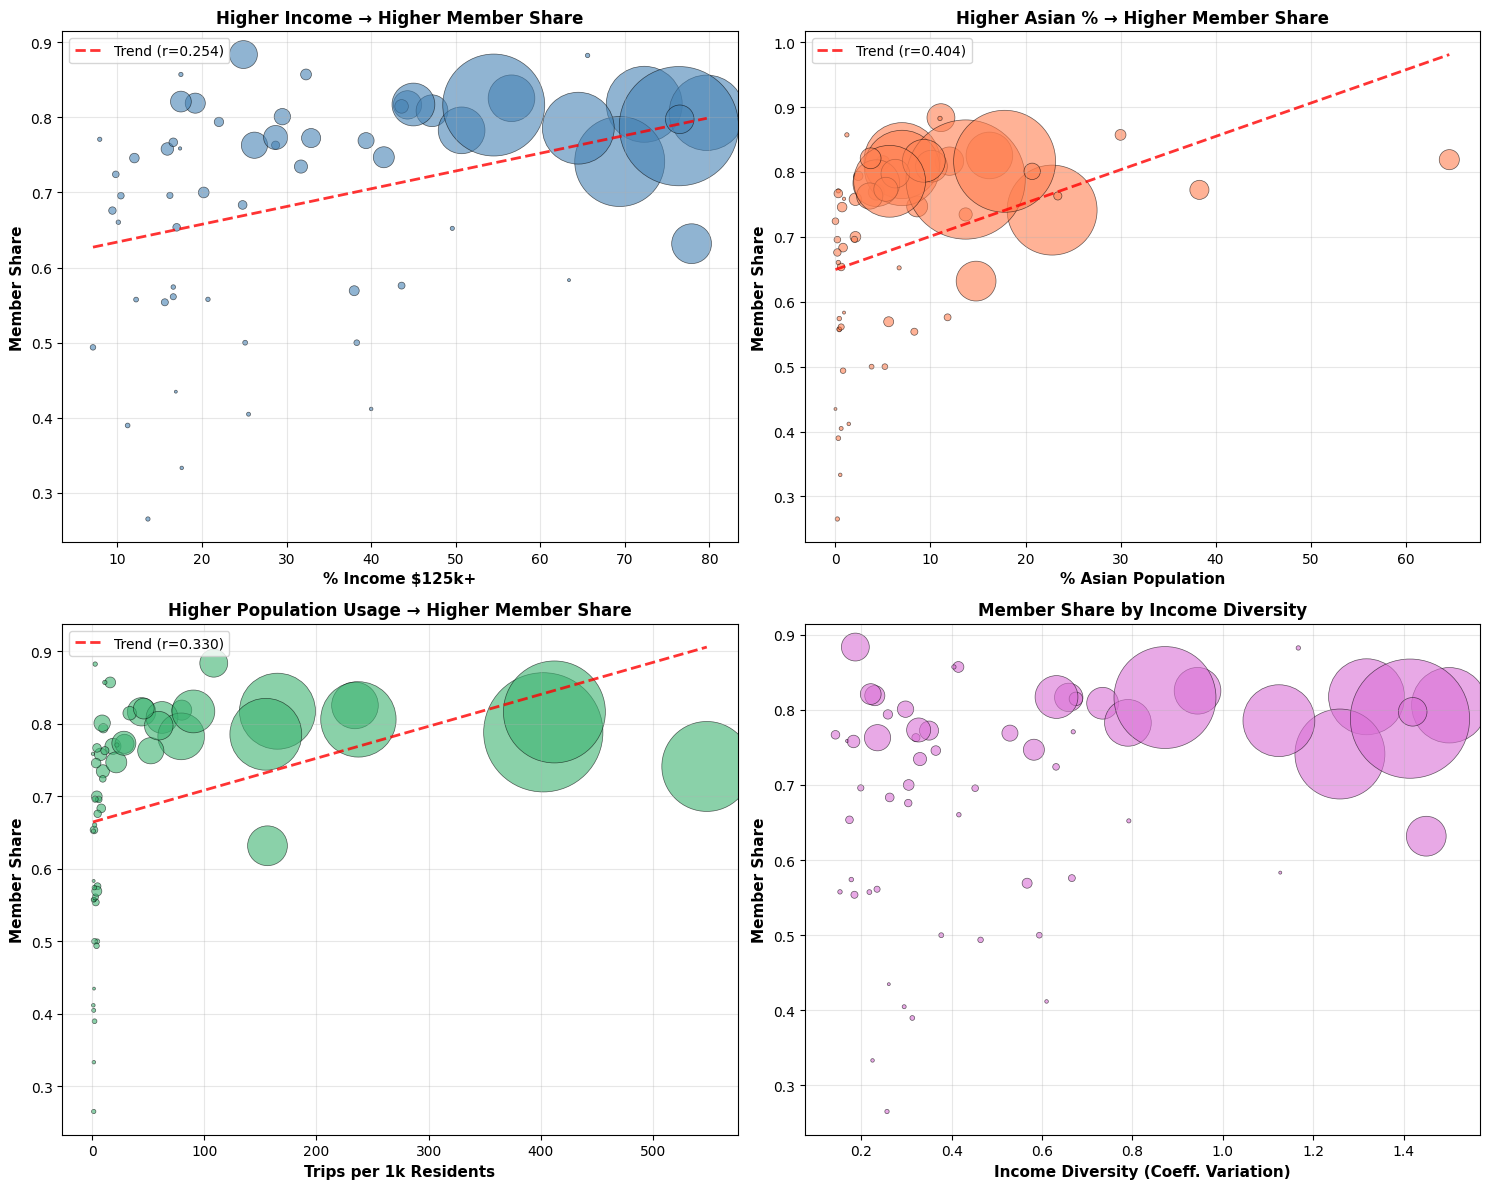

In [39]:
# Visualizations of Demographic-Ridership Relationships

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Income (Highest Bracket %) vs Member Share
ax1 = axes[0, 0]
scatter_data = community_summary[community_summary['total_trips'] > 20].copy()
ax1.scatter(scatter_data['income_125k_plus_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['income_125k_plus_pct'].dropna(), 
               scatter_data.loc[scatter_data['income_125k_plus_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['income_125k_plus_pct'].min(), scatter_data['income_125k_plus_pct'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["income_125k_plus_pct"]:.3f})')
ax1.set_xlabel('% Income $125k+', fontsize=11, fontweight='bold')
ax1.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax1.set_title('Higher Income → Higher Member Share', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Asian % vs Member Share
ax2 = axes[0, 1]
ax2.scatter(scatter_data['asian_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='coral', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['asian_pct'].dropna(), 
               scatter_data.loc[scatter_data['asian_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['asian_pct'].min(), scatter_data['asian_pct'].max(), 100)
ax2.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["asian_pct"]:.3f})')
ax2.set_xlabel('% Asian Population', fontsize=11, fontweight='bold')
ax2.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax2.set_title('Higher Asian % → Higher Member Share', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Population Density (Trips per 1k) vs Member Share
ax3 = axes[1, 0]
density_data = scatter_data[scatter_data['trips_per_1k_residents'].notna()]
ax3.scatter(density_data['trips_per_1k_residents'], density_data['member_share'], 
            s=density_data['total_trips']/5, alpha=0.6, color='mediumseagreen', edgecolors='black', linewidth=0.5)
z = np.polyfit(density_data['trips_per_1k_residents'], density_data['member_share'], 1)
p = np.poly1d(z)
x_line = np.linspace(density_data['trips_per_1k_residents'].min(), density_data['trips_per_1k_residents'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["trips_per_1k_residents"]:.3f})')
ax3.set_xlabel('Trips per 1k Residents', fontsize=11, fontweight='bold')
ax3.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax3.set_title('Higher Population Usage → Higher Member Share', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Income Diversity (Coefficient of Variation) vs Member Share
ax4 = axes[1, 1]
diversity_data = scatter_data[scatter_data['income_diversity_cv'].notna()]
ax4.scatter(diversity_data['income_diversity_cv'], diversity_data['member_share'], 
            s=diversity_data['total_trips']/5, alpha=0.6, color='orchid', edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Income Diversity (Coeff. Variation)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax4.set_title('Member Share by Income Diversity', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis 4
*By Isabella Yan (Chisa)*

#### Step 1: Check distribution of data and log transform to avoid right skewedness

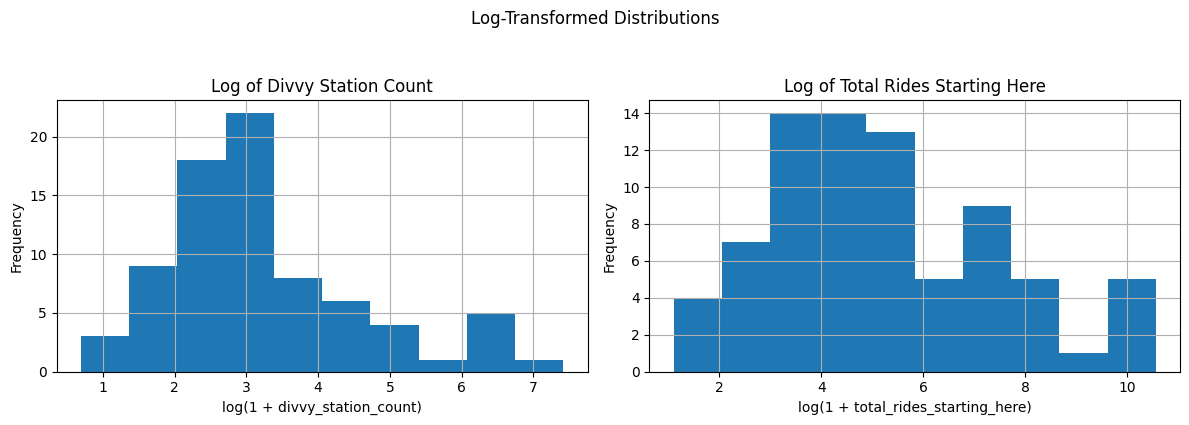

In [40]:
#
# 1.1. Check distribution of data
#

cols = [
    'physical_inactivity_rate',
    'traffic_crashes',
    'divvy_station_count',
    'total_rides_starting_here'
]

# Log-transformed histograms (for skewed variables)
log_cols = ['divvy_station_count', 'total_rides_starting_here']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compute log-transformed data
log_data = community_stats[log_cols].apply(np.log1p)

# Plot histograms
log_data.hist(ax=axes)

# Add titles and axis labels
axes[0].set_title("Log of Divvy Station Count")
axes[0].set_xlabel("log(1 + divvy_station_count)")
axes[0].set_ylabel("Frequency")

axes[1].set_title("Log of Total Rides Starting Here")
axes[1].set_xlabel("log(1 + total_rides_starting_here)")
axes[1].set_ylabel("Frequency")

fig.suptitle("Log-Transformed Distributions", y=1.05)

plt.tight_layout()
plt.show()


#### Step 2: Observe correlations between key variables

In [41]:
#
# 2.1. Look at correlations
#
community_stats[['physical_inactivity_rate',
                 'traffic_crashes',
                 'divvy_station_count',
                 'total_rides_starting_here']].corr()


,physical_inactivity_rate,traffic_crashes,divvy_station_count,total_rides_starting_here
physical_inactivity_rate,1.000000,-0.177478,-0.468223,-0.490147
traffic_crashes,-0.177478,1.000000,0.643516,0.670118
divvy_station_count,-0.468223,0.643516,1.000000,0.974841
total_rides_starting_here,-0.490147,0.670118,0.974841,1.000000


#### Step 3: Use scatterplots to visualize relationships between variables

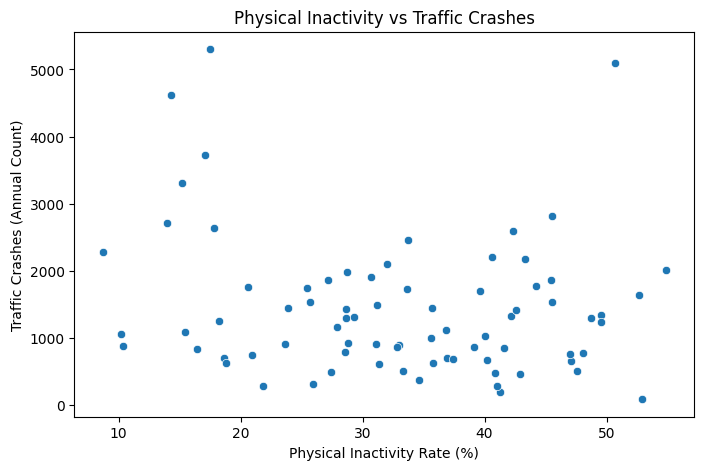

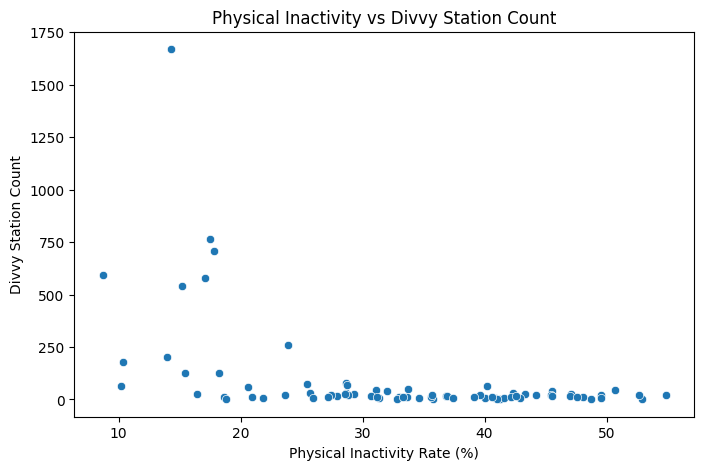

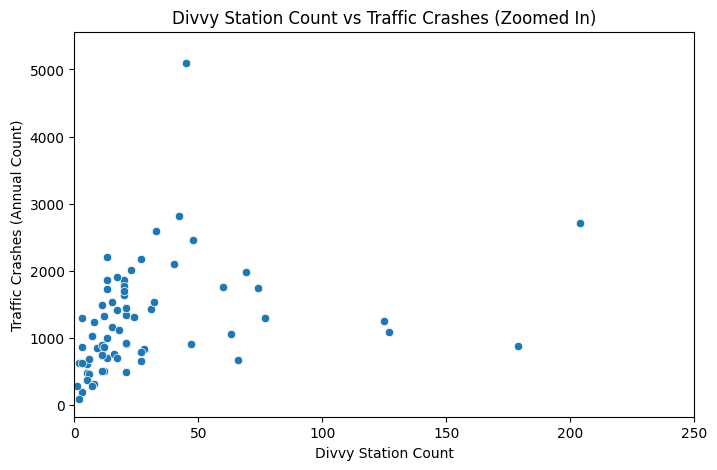

In [42]:
#
# 3.1. Use scatterplots to visualize relationships
#

# convert to numeric values
community_stats['physical_inactivity_rate'] = pd.to_numeric(
    community_stats['physical_inactivity_rate'], errors='coerce'
)

community_stats['traffic_crashes'] = pd.to_numeric(
    community_stats['traffic_crashes'], errors='coerce'
)

community_stats['divvy_station_count'] = pd.to_numeric(
    community_stats['divvy_station_count'], errors='coerce'
)

# Physical inactivity vs traffic crashes
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='traffic_crashes'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Physical Inactivity vs Traffic Crashes")
plt.show()

# Physical inactivity vs Divvy station count
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='divvy_station_count'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Divvy Station Count")
plt.title("Physical Inactivity vs Divvy Station Count")
plt.show()

# Divvy station count vs traffic crashes (zoomed)
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='divvy_station_count',
    y='traffic_crashes'
)
plt.xlim(0, 250)   # zoom for better visibility
plt.xlabel("Divvy Station Count")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Divvy Station Count vs Traffic Crashes (Zoomed In)")
plt.show()

#### Step 4: Create choropleths to visualize key variable distribution in the context of Chicago community areas

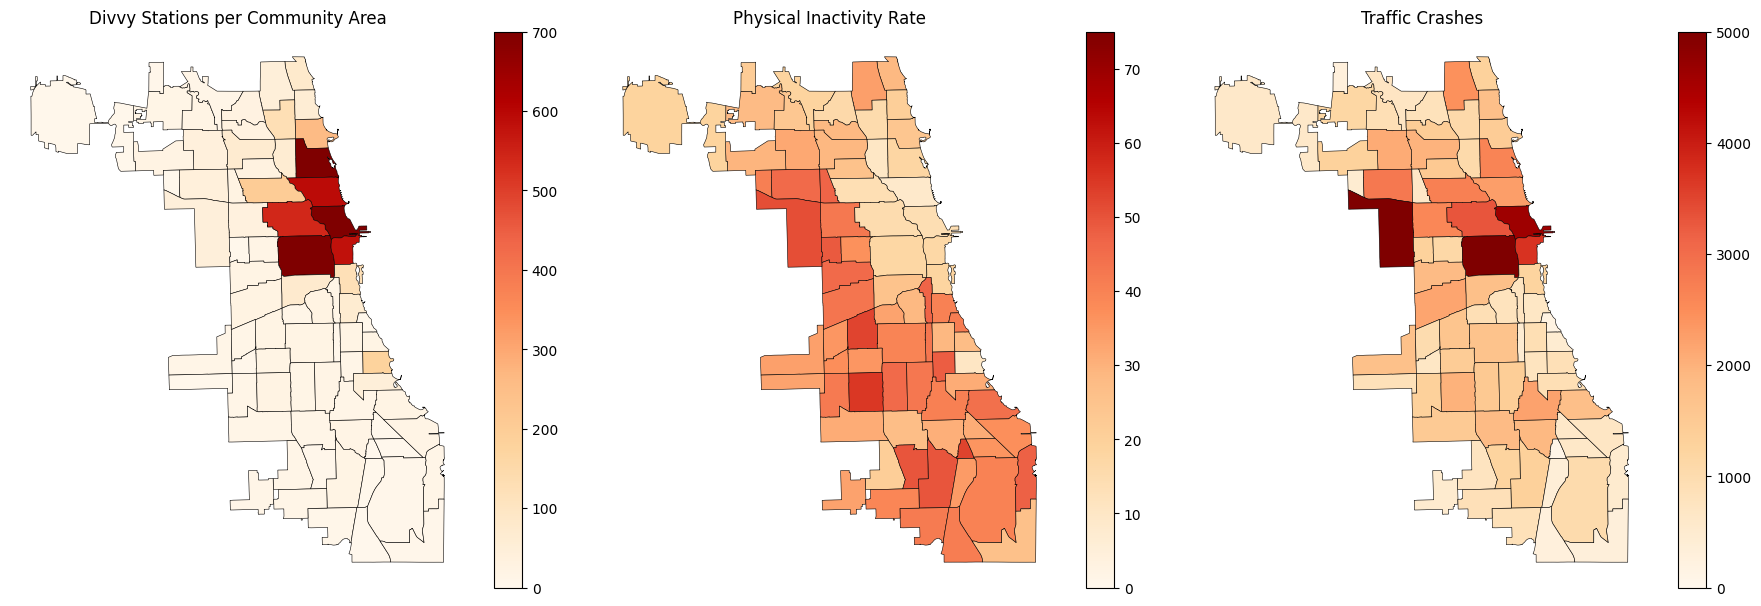

In [43]:
#
# 5.4 Create maps with key variables
#
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# convert WKT geometry column to shapely
community_boundary_data["geometry"] = community_boundary_data["wkt_geometry"].apply(wkt.loads)

gdf = gpd.GeoDataFrame(
    community_boundary_data,
    geometry="geometry",
    crs="EPSG:4326"
)

gdf["community_area_number"] = gdf["community_area_number"].astype(int)
community_stats["community_area_number"] = community_stats["community_area_number"].astype(int)

# merge 
gdf_merged = gdf.merge(community_stats, on="community_area_number", how="left")

# boundary geometry becomes geometry_x
gdf_merged = gdf_merged.set_geometry("geometry_x")

# remove centroid geometry from stats
if "geometry_y" in gdf_merged.columns:
    gdf_merged = gdf_merged.drop(columns=["geometry_y"])

# 3 variables we want to map 
columns_to_map = [
    ("divvy_station_count", "Divvy Stations per Community Area", 0, 700),
    ("physical_inactivity_rate", "Physical Inactivity Rate", 0, 75),
    ("traffic_crashes", "Traffic Crashes", 0, 5000),
]

# set up 3 plots 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for ax, (col, title, vmin, vmax) in zip(axes, columns_to_map):
    gdf_merged.plot(
        column=col,
        cmap="OrRd",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=0.4,
        ax=ax
    )
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()
